# Calibration of layer weights
Minimizing 
$$\frac{1}{N_{\text{evts}}} \sum_{i=1}^{N_{\text{evts}}} \left( \frac{ \sum_{l=1}^{28} w_l E_i^{\text{layer } l} }{E^{\text{gun}}_{i}} - 1 \right)^2$$

In [1]:
%load_ext autoreload
%autoreload 1
import sys
import os
sys.path.append("../..")

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset

from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
%aimport ml.calibration.energy_distribution_from_weights
from ml.calibration.energy_distribution_from_weights import WeightedLayersComputations
from ml.plot_utils import plotLossPerEpoch

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-torch/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-torch/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
reader_sim = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
reader_data = ClueNtupleReader(reader_sim.version, reader_sim.clueParams, "data")
full_dataset = TensorDataset(*torch.load(os.path.join(reader_sim.pathToFolder, "energyPerLayer.pt")))

In [3]:
totalev = len(full_dataset)
ntrain = int(0.8*totalev)
ntest = totalev - ntrain

ntrainbatch = 200
ntestbatch = 100
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [ntrain, ntest])
trainloader = DataLoader(train_dataset, batch_size=ntrainbatch, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=ntestbatch, shuffle=True)

In [25]:
len(train_dataset)

282697

In [4]:
class Model(torch.nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        
        super().__init__()
        # initialize weights with random numbers
        #weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        #weights = torch.ones(size=(28,),requires_grad=True,dtype=torch.float)
        weights = torch.normal(mean=torch.ones(size=(28,)), std=torch.ones(size=(28,))*0.5)
        # make weights torch parameters
        self.weights = torch.nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised.
        """
        batch_size = X.shape[0]
        output = X*self.weights.repeat(batch_size,1) # tensor (batchItem, layer) with weighted energy for each layer
        return torch.sum(output,dim=-1) # sum energies over all layer per item

In [5]:
#device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

mse = torch.nn.MSELoss()
def lossComputation(result:torch.Tensor, trueBeamEnergy:torch.Tensor):
    # return mse(result, data[1])  # Loss is MSE of E_estimate - E_beam
    return mse(result/trueBeamEnergy, torch.ones_like(result))  # Loss is MSE of E_estimate / E_beam wrt to 1


lossc,lossr = [],[]
epochs = []
opt = torch.optim.Adam(model.parameters(), lr=0.001)
#opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=1e-1)#, nesterov=True)

def train(epoch):
    model.train()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            optimizer.zero_grad()
            result = model(data[0])

            lossc = lossComputation(result, data[1])

            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))



def evaluate(epoch):
    model.eval()
    #torch.cuda.empty_cache()
    #scheduler.step()
    loss = []
    pred = []
    true = []
    calc = []
    for data in tqdm(testloader):
            data[0] = data[0].to(device)
            data[1] = data[1].to(device)
            #print(data[0])
            optimizer.zero_grad()
            result = model(data[0])
            #print(result)
            lossc = lossComputation(result, data[1])
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            #scheduler.batch_step()
            for i in result:
                pred.append(i.detach().cpu())
                #predc.append(i.detach().cpu().argmax())
            for i in data[1].detach():
                true.append(i.detach().cpu())
            for i in data[0].detach():
                calc.append(torch.sum(i.detach().cpu()))    
    
    if False:
        from matplotlib.pyplot import figure
        figure(figsize=(15, 15), dpi=40)
        #plt.rcParams['axes.labelsize'] = 36
        #plt.rcParams['axes.titlesize'] = 36
        #plt.hist2d(truea,preda,bins=200)
        #plt.scatter(truea,preda,alpha=0.4)
        #plt.scatter(truea,preda,alpha=0.4)
        
        plt.hist(np.array(pred)/np.array(true),bins=100,range=[0.75,1.25],label='pred')
        plt.hist(np.array(calc)/np.array(true),bins=100,range=[0.75,1.25],label='calc')
        #plt.plot([0,2], [0,2], 'k-')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #plt.xlim([-2, 18])
        #plt.ylim([-2, 20])
        plt.axvline(x=1.0,c='r')
        #plt.axhline(y=1.0,c='r')
        plt.legend()
        plt.show()
    
    
    print( 'batches for test:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print("calib weights:",model.weights)
    return np.mean(np.array(loss))




epoch: 0


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0010595157340480491


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0008632226496301934
calib weights: Parameter containing:
tensor([0.8684, 1.5246, 0.6105, 1.1621, 1.1573, 0.9803, 1.1277, 0.4357, 1.5088,
        0.8121, 1.2641, 0.9119, 0.9601, 0.9160, 1.0671, 1.1116, 1.2655, 0.6085,
        1.4614, 0.6408, 0.8039, 1.3415, 0.8419, 1.5321, 1.3897, 0.6624, 1.3556,
        1.3107], requires_grad=True)
new best test loss: 0.0008632226496301934
epoch: 1


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0008132452331244606


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007886104747179442
calib weights: Parameter containing:
tensor([0.8725, 1.3480, 0.7710, 1.1001, 1.0760, 1.0261, 1.0911, 0.7582, 1.2543,
        0.9257, 1.1301, 0.9758, 0.9845, 0.9721, 1.0268, 1.0707, 1.1420, 0.7845,
        1.2838, 0.8339, 0.9307, 1.2647, 0.9707, 1.4214, 1.3257, 0.8919, 1.3193,
        1.5855], requires_grad=True)
new best test loss: 0.0007886104747179442
epoch: 2


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007730072014800456


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007686827371629348
calib weights: Parameter containing:
tensor([0.8964, 1.2386, 0.8688, 1.0670, 1.0339, 1.0370, 1.0511, 0.9109, 1.1190,
        0.9916, 1.0702, 1.0183, 1.0035, 1.0086, 1.0135, 1.0563, 1.0785, 0.8971,
        1.1731, 0.9504, 0.9948, 1.1985, 1.0377, 1.3246, 1.2623, 1.0330, 1.2663,
        1.7930], requires_grad=True)
new best test loss: 0.0007686827371629348
epoch: 3


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007623971690265053


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007644039479939232
calib weights: Parameter containing:
tensor([0.9226, 1.1779, 0.9309, 1.0599, 1.0223, 1.0492, 1.0308, 0.9862, 1.0516,
        1.0223, 1.0368, 1.0331, 1.0047, 1.0218, 1.0037, 1.0492, 1.0415, 0.9566,
        1.1095, 1.0167, 1.0247, 1.1549, 1.0724, 1.2678, 1.2228, 1.1255, 1.2314,
        1.9593], requires_grad=True)
new best test loss: 0.0007644039479939232
epoch: 4


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007596719948129657


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.000763379146426961
calib weights: Parameter containing:
tensor([0.9317, 1.1330, 0.9562, 1.0504, 1.0122, 1.0520, 1.0164, 1.0192, 1.0198,
        1.0373, 1.0211, 1.0412, 1.0031, 1.0264, 0.9933, 1.0393, 1.0210, 0.9810,
        1.0691, 1.0447, 1.0276, 1.1249, 1.0856, 1.2228, 1.1902, 1.1676, 1.2023,
        2.0691], requires_grad=True)
new best test loss: 0.000763379146426961
epoch: 5


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007590571088835602


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007627512096731016
calib weights: Parameter containing:
tensor([0.9495, 1.1163, 0.9779, 1.0503, 1.0151, 1.0583, 1.0118, 1.0391, 1.0068,
        1.0477, 1.0158, 1.0475, 1.0075, 1.0332, 0.9955, 1.0433, 1.0158, 1.0005,
        1.0536, 1.0648, 1.0368, 1.1181, 1.0996, 1.2048, 1.1775, 1.1940, 1.1863,
        2.1650], requires_grad=True)
new best test loss: 0.0007627512096731016
epoch: 6


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.000758811493816356


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007627164306368711
calib weights: Parameter containing:
tensor([0.9574, 1.1014, 0.9856, 1.0476, 1.0127, 1.0592, 1.0086, 1.0472, 1.0008,
        1.0514, 1.0113, 1.0475, 1.0056, 1.0324, 0.9928, 1.0410, 1.0125, 1.0105,
        1.0430, 1.0715, 1.0380, 1.1079, 1.1043, 1.1861, 1.1648, 1.2126, 1.1754,
        2.2392], requires_grad=True)
new best test loss: 0.0007627164306368711
epoch: 7


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.000758803259449434


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007632967987647108
calib weights: Parameter containing:
tensor([0.9600, 1.0894, 0.9861, 1.0428, 1.0085, 1.0577, 1.0049, 1.0500, 0.9968,
        1.0522, 1.0089, 1.0471, 1.0047, 1.0324, 0.9930, 1.0385, 1.0094, 1.0119,
        1.0350, 1.0736, 1.0362, 1.1018, 1.1023, 1.1752, 1.1582, 1.2190, 1.1678,
        2.2855], requires_grad=True)
epoch: 8


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.0007586116386359146


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007629829792824838
calib weights: Parameter containing:
tensor([0.9611, 1.0869, 0.9887, 1.0417, 1.0098, 1.0585, 1.0057, 1.0528, 0.9961,
        1.0561, 1.0117, 1.0504, 1.0079, 1.0364, 0.9978, 1.0436, 1.0121, 1.0171,
        1.0363, 1.0795, 1.0412, 1.1021, 1.1093, 1.1743, 1.1552, 1.2295, 1.1623,
        2.3248], requires_grad=True)
epoch: 9


  0%|          | 0/1414 [00:00<?, ?it/s]

batches for train: 1414
train loss: 0.000758764976221453


  0%|          | 0/707 [00:00<?, ?it/s]

batches for test: 707
test loss: 0.0007628565714671507
calib weights: Parameter containing:
tensor([0.9668, 1.0886, 0.9950, 1.0459, 1.0122, 1.0596, 1.0052, 1.0537, 0.9961,
        1.0577, 1.0125, 1.0533, 1.0098, 1.0378, 0.9963, 1.0455, 1.0137, 1.0198,
        1.0374, 1.0835, 1.0439, 1.1006, 1.1114, 1.1708, 1.1562, 1.2264, 1.1550,
        2.3541], requires_grad=True)


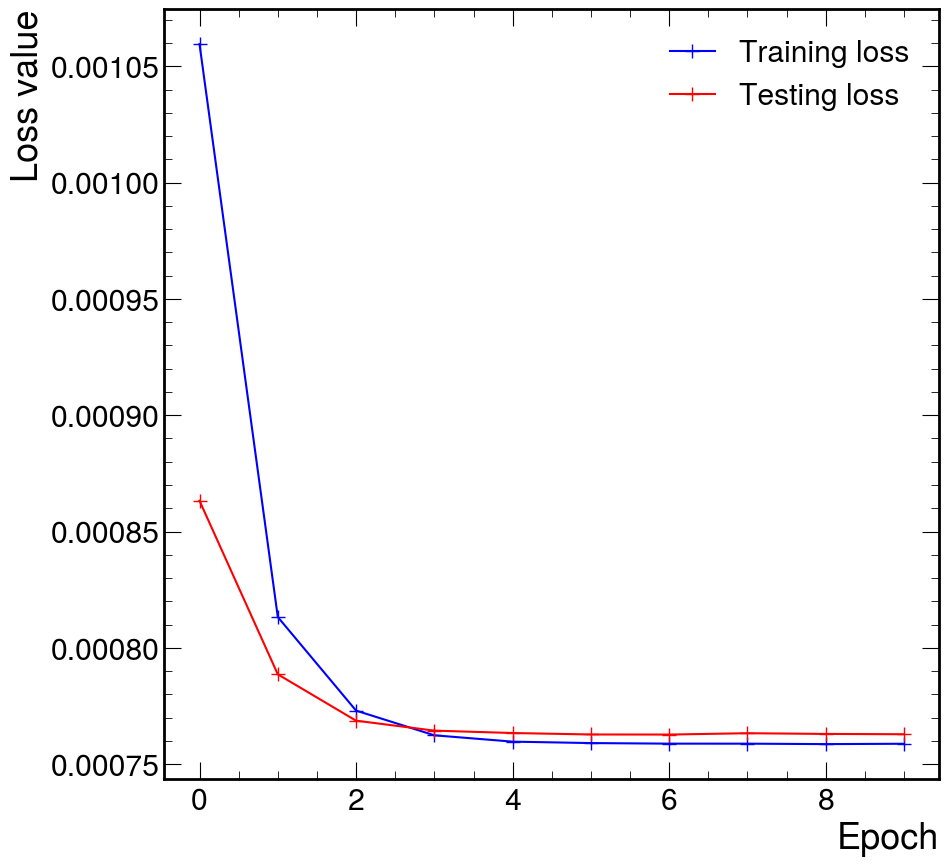

In [6]:
nepoch=10
#os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch = evaluate(epoch)
    lossv.append(loss_epoch)
    epochs.append(epoch)
    #checkpoint = {
    #'epoch': epoch + 1,
    #'state_dict': model.state_dict(),
    #'optimizer': optimizer.state_dict()
    #}
    
    #checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    #torch.save(checkpoint,
    #               os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        #torch.save(checkpoint,
        #           os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if ((epoch+1)%10 == 0):
        plotLossPerEpoch(epochs, losst, lossv)

In [7]:
parameters = list(model.parameters())[0].detach().cpu().numpy()
weightsAsDict = dict(zip(range(1, 28+1), parameters))
parameters

array([0.96683025, 1.088558  , 0.99497414, 1.0458539 , 1.0122145 ,
       1.0595751 , 1.0051559 , 1.0536569 , 0.99609244, 1.0577314 ,
       1.0125068 , 1.0533168 , 1.0097567 , 1.0377661 , 0.99634635,
       1.0455338 , 1.0137408 , 1.0198419 , 1.037404  , 1.0834543 ,
       1.0439043 , 1.1005762 , 1.1114156 , 1.1707827 , 1.1562303 ,
       1.2264341 , 1.1549914 , 2.3540554 ], dtype=float32)

In [8]:
weightedComp_sim = WeightedLayersComputations(weightsAsDict, reader_sim)
weightedComp_data = WeightedLayersComputations(weightsAsDict, reader_data)

In [9]:
# import importlib
# import ml.calibration.energy_distribution_from_weights
# importlib.reload(ml.calibration.energy_distribution_from_weights).WeightedLayersComputations.plotDeDxWeights(weightedComp)
# None

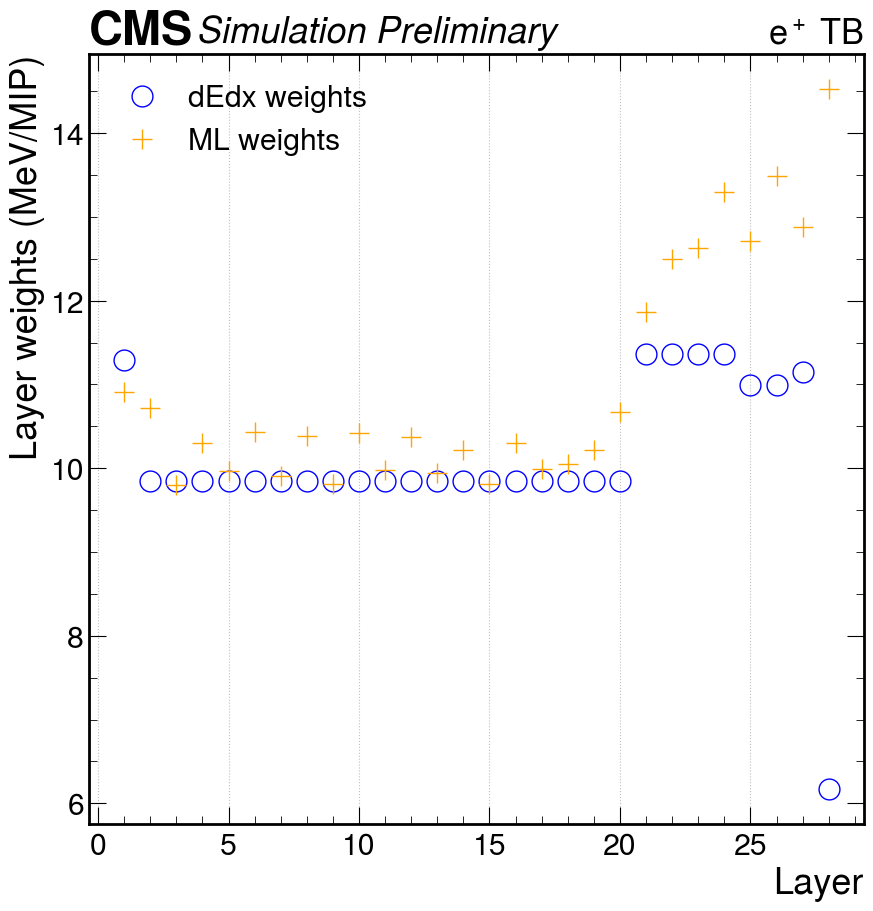

In [10]:
weightedComp_sim.plotDeDxWeights()
None # NB : in longitudinal profiles, even layer have a dip, odd have a bump

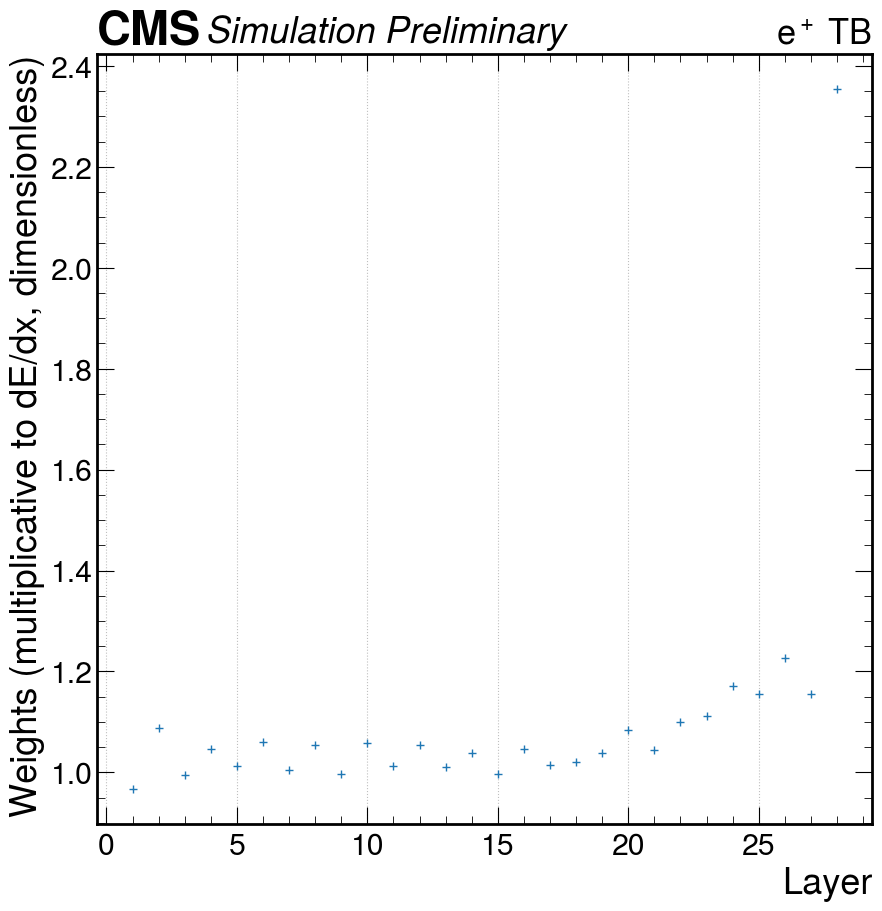

In [11]:
weightedComp_sim.plotRelativeWeights()
None

In [12]:
weightedComp_sim.compute()


Histogramming with weighted layers:   0%|          | 0/359937 [00:00<?, ?it/s]

In [13]:
weightedComp_data.compute()

Histogramming with weighted layers:   0%|          | 0/272855 [00:00<?, ?it/s]

<Axes: xlabel='$S (\\sqrt{GeV} \\%)$', ylabel='C (%)'>

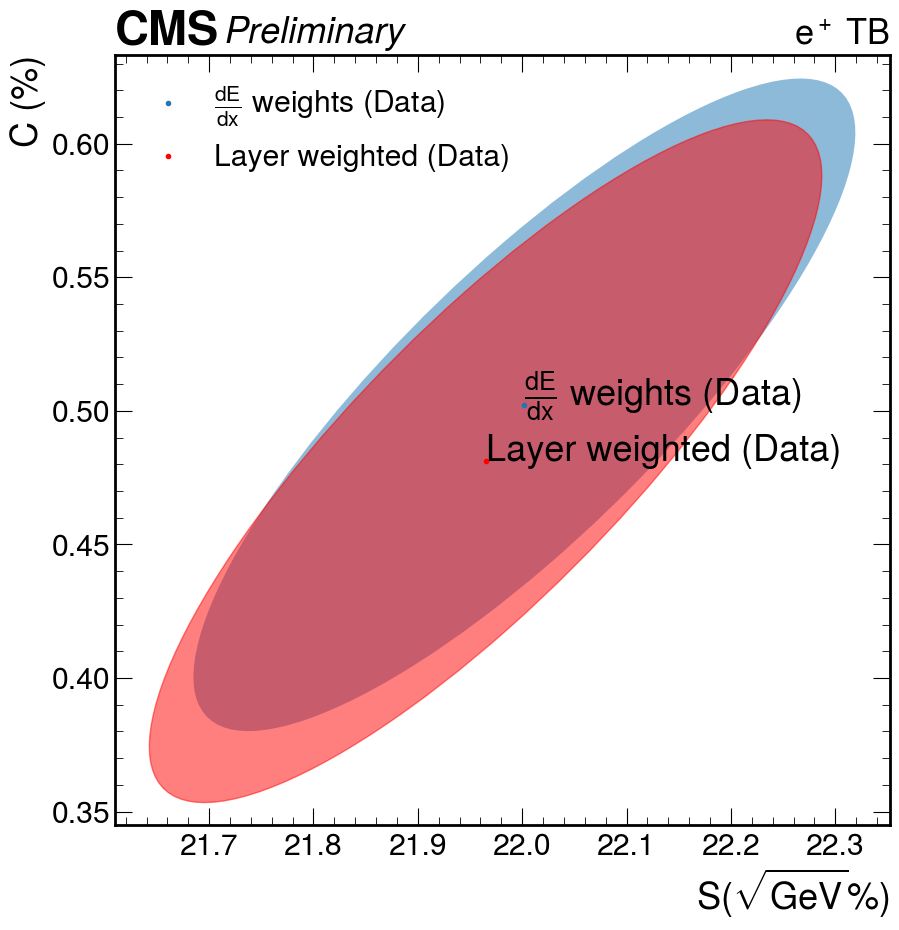

In [28]:
from energy_resolution.sigma_over_e import SigmaOverEPlotElement, plotSCAsEllipse, plotSigmaOverMean, sigmaOverE_fitFunction
import mplhep as hep
plotSCAsEllipse([
    reader_data.loadSigmaOverEResults("rechits")._replace(legend="$\\frac{dE}{dx}$ weights (Data)"),
    SigmaOverEPlotElement(legend="Layer weighted (Data)", fitResult=weightedComp_data.sigmaOverE, color="red")
])
hep.cms.text("Preliminary")
hep.cms.lumitext("$e^+$ TB")

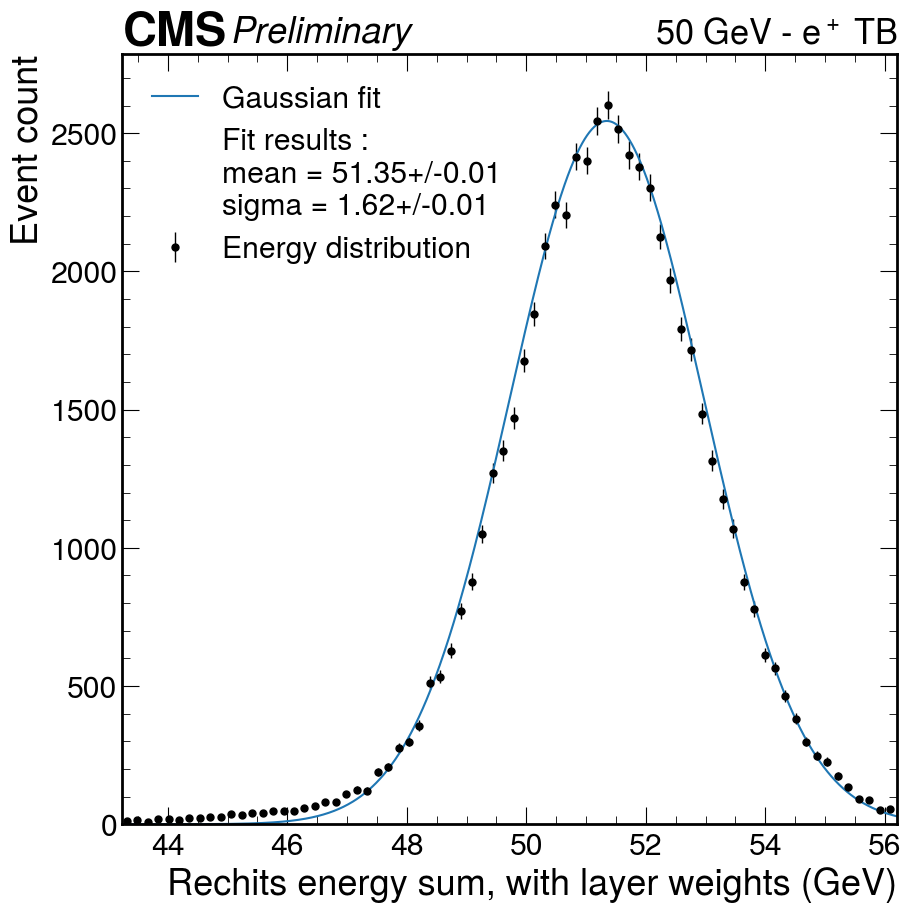

In [23]:
weightedComp_data.sigmaOverEComputation.plotFitResult(50)

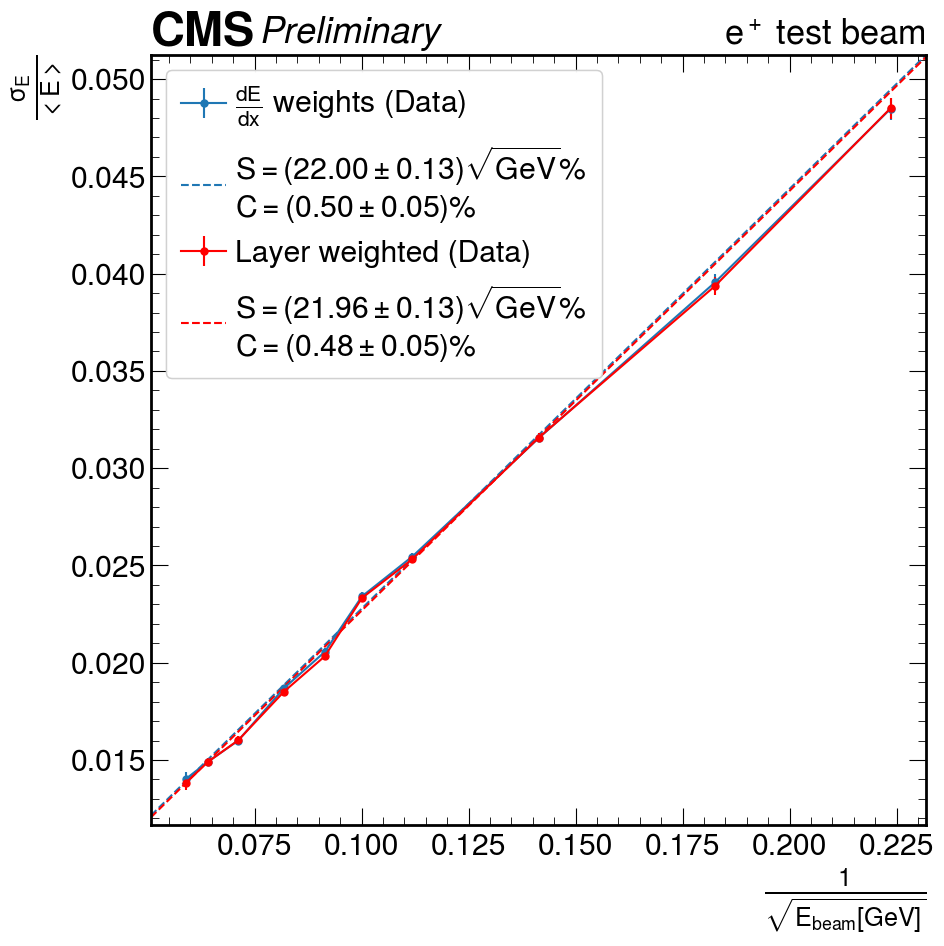

In [32]:
plotSigmaOverMean([
    reader_data.loadSigmaOverEResults("rechits")._replace(legend="$\\frac{dE}{dx}$ weights (Data)"),
    SigmaOverEPlotElement(legend="Layer weighted (Data)", fitResult=weightedComp_data.sigmaOverE, color="red", fitFunction=sigmaOverE_fitFunction,
                          dataPoints={beamEnergy : result.sigma / result.mu for beamEnergy, result in weightedComp_data.sigmaOverEComputation.results.items()})
    ], xMode="1/sqrt(E)", plotFit=True)

Fitting:   0%|          | 0/10 [00:00<?, ?it/s]

Iterative fitting - 20 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 30 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 50 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 80 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 100 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 120 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 149 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 198 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 244 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

Iterative fitting - 288 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

<Axes: xlabel='$S (\\sqrt{GeV} \\%)$', ylabel='C (%)'>

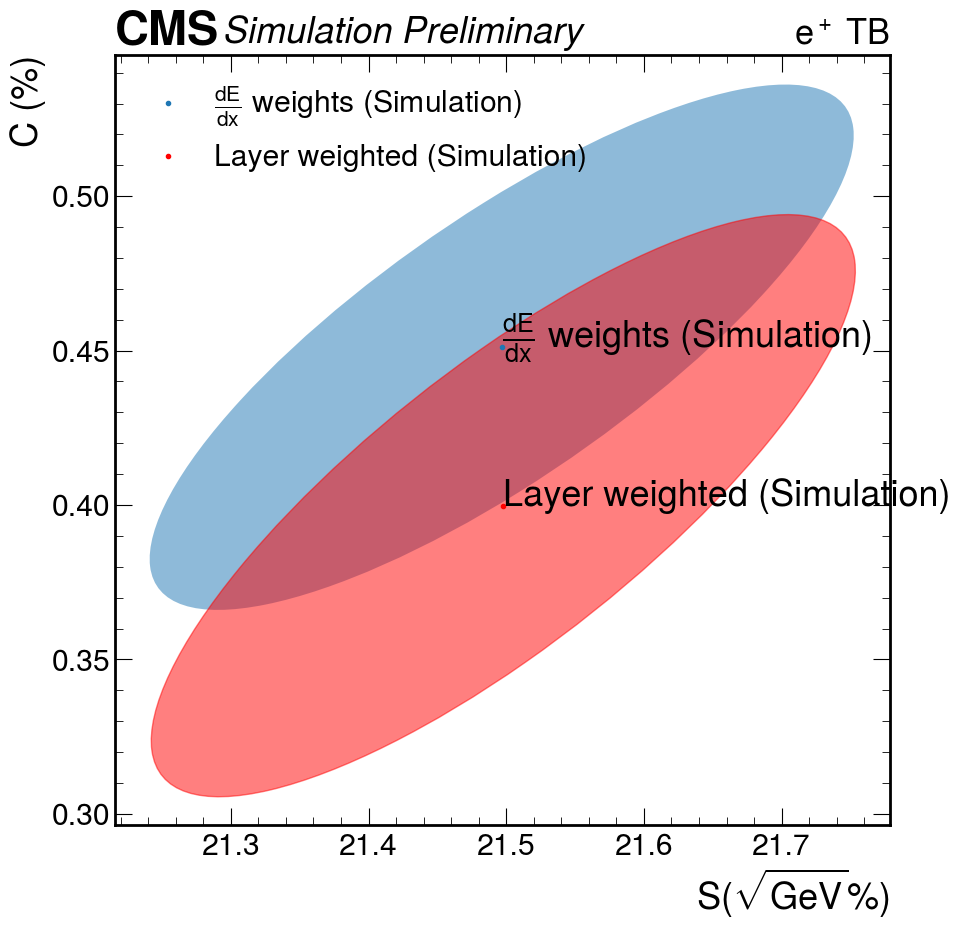

In [24]:
plotSCAsEllipse([
    reader_sim.loadSigmaOverEResults("rechits")._replace(legend="$\\frac{dE}{dx}$ weights (Simulation)"),
    SigmaOverEPlotElement(legend="Layer weighted (Simulation)", fitResult=weightedComp_sim.sigmaOverE, color="red")
])
hep.cms.text("Simulation Preliminary")
hep.cms.lumitext("$e^+$ TB")

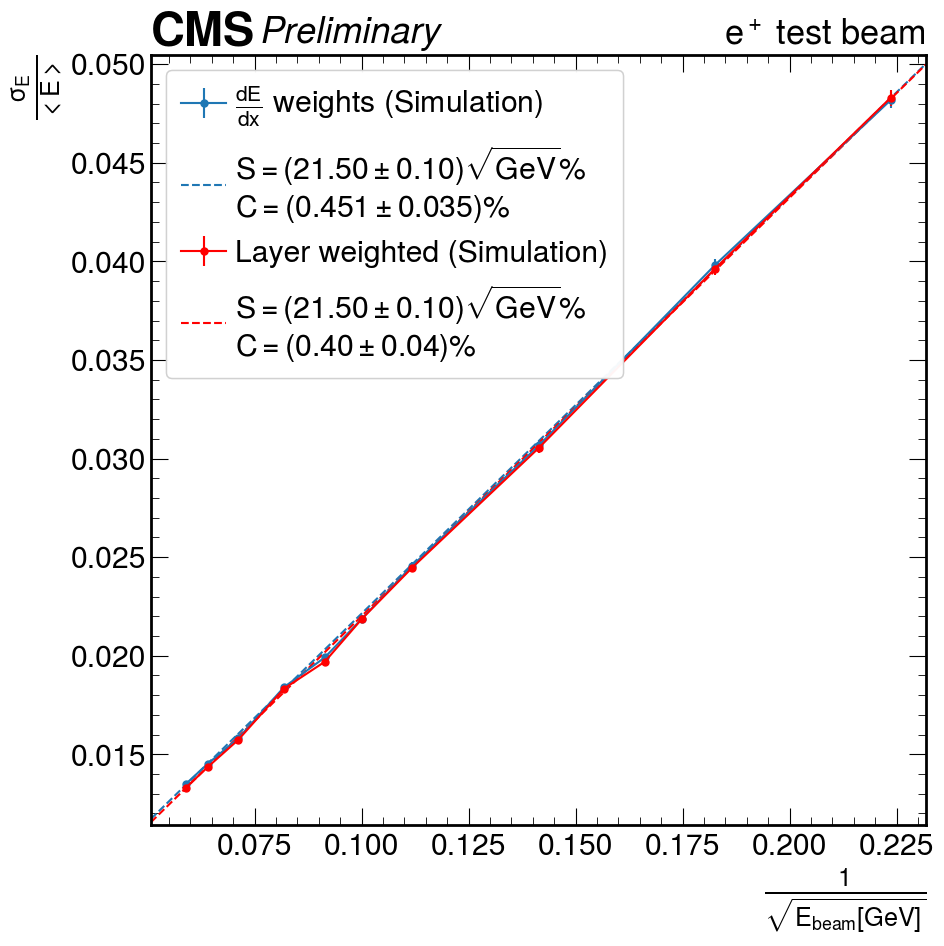

In [33]:
plotSigmaOverMean([
    reader_sim.loadSigmaOverEResults("rechits")._replace(legend="$\\frac{dE}{dx}$ weights (Simulation)"),
    SigmaOverEPlotElement(legend="Layer weighted (Simulation)", fitResult=weightedComp_sim.sigmaOverE, color="red", fitFunction=sigmaOverE_fitFunction,
                          dataPoints={beamEnergy : result.sigma / result.mu for beamEnergy, result in weightedComp_sim.sigmaOverEComputation.results.items()})
    ], xMode="1/sqrt(E)", plotFit=True)

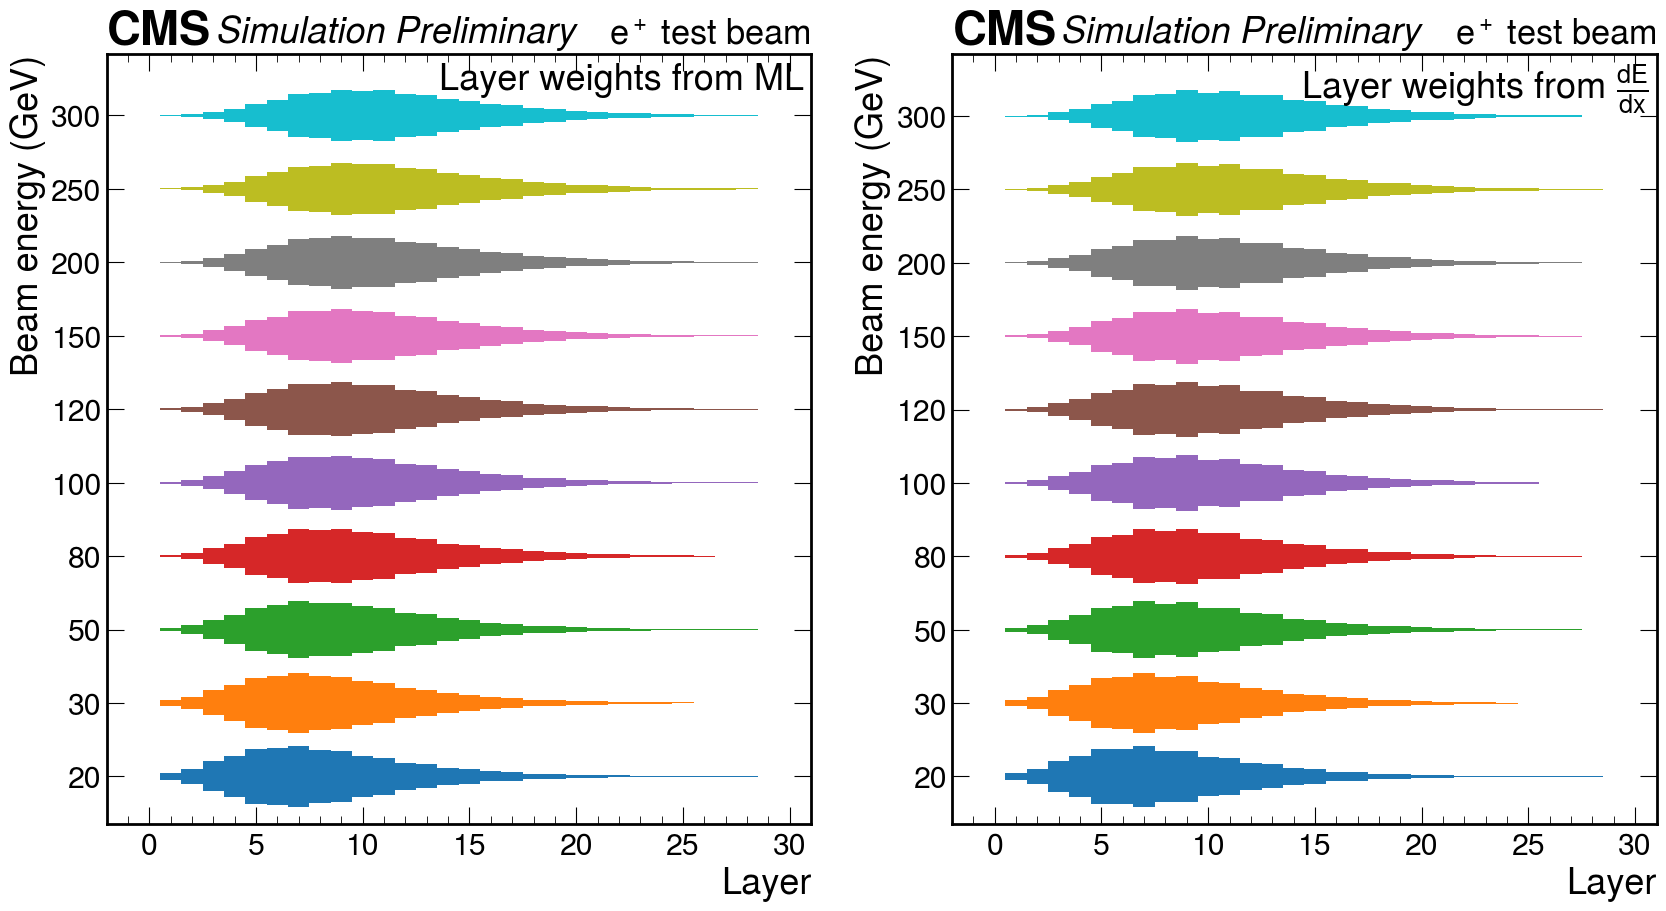

In [ ]:
weightedComp.plotViolin()
None